# Human Connectome Predicting intelligence quotent
## Notebook Objectives:
* read in the connectome data
* with the sample data, create an binary, ternary, and continuous models to predict the IQ of a given connectome.
* plot the results of the classificaiton models
* design a pipeline to run the models through
* produce descriptive statistics on each model

In [159]:
# Import all of the relative packages
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

## Data Importing
This next section is where data is imported and built. Many of the arrays and dicts are unused, but were helpful in getting to know the data. 

In [160]:
# init an ids array
ids = []
#open and read line-by-line the id names
with open('/home/thomas/git/datascience/MSDataSci/505/data/project_three/ids.txt') as id_file:
    for line in id_file:
        line = line.replace('.txt\n','')
        ids.append(line)

# init several arrays to hold data
iqs = []
iqs_labels = []
iqs_binary_labels = []
iqs_ternary_labels = []
matrices = []
vectors = []
data_dict = {}
i = 0
# loop through ids and append the data to the empty arrays accordingly
for id in ids:
    data_dict[id] = {}
    with open('/home/thomas/git/datascience/MSDataSci/505/data/project_three/dataset/{}.txt'.format(id)) as iq_file:
        iq = float(iq_file.readline().replace('\n',''))
        iqs.append(np.array([iq]))
        iqs_labels.append([iq,int(0 if iq<100 else 1),str('above average' if iq>110 else ('below average' if iq<90 else 'average'))])
        iqs_binary_labels.append(0 if iq<100 else 1)
        iqs_ternary_labels.append(2 if iq>110 else (0 if iq<90 else 1))
        data_dict[id]['iq'] = [iq,int(0 if iq<100 else 1),str('above average' if iq>110 else ('below average' if iq<90 else 'average'))]
    
    matrix = np.genfromtxt('/home/thomas/git/datascience/MSDataSci/505/data/project_three/dataset/{}.csv'.format(id),delimiter=',') 
    vector = np.array([np.array(np.genfromtxt('/home/thomas/git/datascience/MSDataSci/505/data/project_three/dataset/{}_vec.csv'.format(id),delimiter=','))])

    matrices.append(matrix)
    vectors.append(vector[0])

    data_dict[id]['pid'] = i
    data_dict[id]['matrix'] = matrix
    data_dict[id]['vector'] = vector

    i += 1
    
# converting the arrays to np arrays helps later
iqs_binary_labels = np.array(iqs_binary_labels)
matrices = np.array(matrices)
vects = np.array(vectors)
iqs = np.array(iqs)
iqs_binary_labels = np.array(iqs_binary_labels)
iqs_ternary_labels = np.array(iqs_ternary_labels)

# load regions data
regions = list(csv.reader(open("/home/thomas/git/datascience/MSDataSci/505/data/project_three/Atlas_regions.csv")))

# PCA

In [162]:
pca = PCA(n_components=10)
pca.fit(vects)
vectors = pca.fit_transform(vectors)

# Binary Classification

/home/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


precision: [0. 0. 0.]
recall: [0. 0. 0.]
fscore: [0. 0. 0.]
support: [ 9 29  0]
Fold Score: 0.95
-----------------------
precision: [0. 0. 0.]
recall: [0. 0. 0.]
fscore: [0. 0. 0.]
support: [ 6 33  0]
Fold Score: 0.95
-----------------------
precision: [0. 0. 0.]
recall: [0. 0. 0.]
fscore: [0. 0. 0.]
support: [ 7 32  0]
Fold Score: 1.00
-----------------------


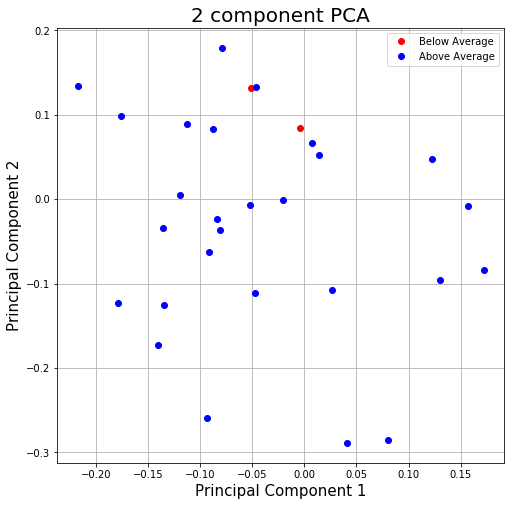

In [163]:
# init the pipeline
bin_pipeline = Pipeline([('feature_selection',PCA()),
                     ('scaling',StandardScaler()),
                     ('classifier',LogisticRegression(multi_class='auto',solver='liblinear'))])

# set up k folds
kf = KFold(n_splits=3,shuffle=True)
kf.get_n_splits(vectors)

# loop through folds and execute the pipeline
for test_idx, train_idx in kf.split(vectors):

    # apply folds indices
    vectors_train, vectors_test = vectors[train_idx], vectors[test_idx]
    iqs_binary_labels_train, iqs_binary_labels_test = iqs_binary_labels[train_idx], iqs_binary_labels[test_idx]

    # fit the pipeline
    bin_pipeline.fit(vectors_train,iqs_binary_labels_train)
    score = bin_pipeline.score(vectors_train,iqs_binary_labels_train)
    bin_scores.append(score)
    Yhat = pipeline.predict(vectors_test)
    
    # calcualte descriptive stats
    metrics = precision_recall_fscore_support(iqs_binary_labels_test,Yhat)
    print('precision: {}'.format(str(metrics[0])))
    print('recall: {}'.format(str(metrics[1])))
    print('fscore: {}'.format(str(metrics[2])))
    print('support: {}'.format(str(metrics[3])))
    print('Fold Score: {0:0.2f}'.format(score))
    print('-----------------------')
    
# create the plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
red_group = []
green_group = []
blue_group = []
for i in range(len(iqs_ternary_labels_test)):
    lab=iqs_ternary_labels_test[i]
    if lab == 0:
        red_group.append([vectors_test[i,0],vectors_test[i,1]])
    else:
        blue_group.append([vectors_test[i,0],vectors_test[i,1]])
        
ax.plot(np.array(red_group)[:,0], np.array(red_group)[:,1], marker='o', linestyle='', label='Below Average', color = 'r')
ax.plot(np.array(blue_group)[:,0], np.array(blue_group)[:,1], marker='o', linestyle='', label='Above Average', color = 'b')
ax.legend()
ax.grid()

## Ternary Calssificaiton

/home/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: [0.         0.         0.62068966]
recall: [0. 0. 1.]
fscore: [0.         0.         0.76595745]
support: [ 4  7 18]
Fold Score: 0.93
precision: [0.         0.         0.51724138]
recall: [0. 0. 1.]
fscore: [0.         0.         0.68181818]
support: [ 2 12 15]
Fold Score: 0.83


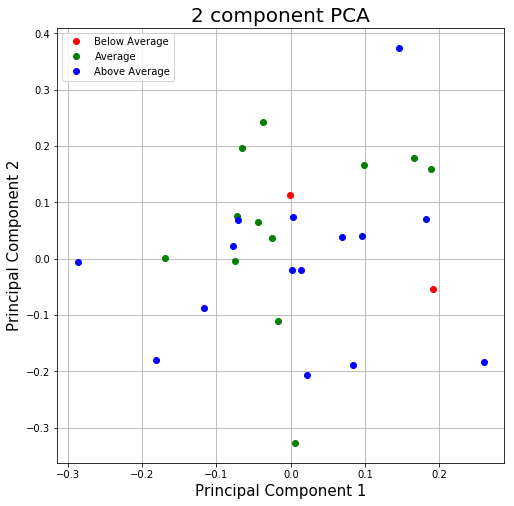

In [153]:
# init the pipeline
ter_pipeline = Pipeline([('feature_selection',PCA()),
                         ('scaling',StandardScaler()),
                         ('classifier',SVC())])

# set up k folds
kf = KFold(n_splits=2,shuffle=True)
kf.get_n_splits(vectors)

# loop through folds and execute the pipeline
for test_idx, train_idx in kf.split(vectors):
    #apply folds indices
    vectors_train, vectors_test = vectors[train_idx], vectors[test_idx]
    iqs_ternary_labels_train, iqs_ternary_labels_test = iqs_ternary_labels[train_idx], iqs_ternary_labels[test_idx]
    
    # fit the model
    ter_pipeline.fit(vectors_train,iqs_ternary_labels_train)
    score = ter_pipeline.score(vectors_train,iqs_ternary_labels_train)
    bin_scores.append(score)
    Yhat = pipeline.predict(vectors_test)
    
    # calcualte descriptive stats
    metrics = precision_recall_fscore_support(iqs_ternary_labels_test,Yhat)
    print('precision: {}'.format(str(metrics[0])))
    print('recall: {}'.format(str(metrics[1])))
    print('fscore: {}'.format(str(metrics[2])))
    print('support: {}'.format(str(metrics[3])))
    print('Fold Score: {0:0.2f}'.format(score))

# plot the results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
red_group = []
green_group = []
blue_group = []
for i in range(len(iqs_ternary_labels_test)):
    lab=iqs_ternary_labels_test[i]
    if lab == 0:
        red_group.append([vectors_test[i,0],vectors_test[i,1]])
    elif lab == 1:
        green_group.append([vectors_test[i,0],vectors_test[i,1]])
    else:
        blue_group.append([vectors_test[i,0],vectors_test[i,1]])
        
ax.plot(np.array(red_group)[:,0], np.array(red_group)[:,1], marker='o', linestyle='', label='Below Average', color = 'r')
ax.plot(np.array(green_group)[:,0], np.array(green_group)[:,1], marker='o', linestyle='', label='Average', color = 'g')
ax.plot(np.array(blue_group)[:,0], np.array(blue_group)[:,1], marker='o', linestyle='', label='Above Average', color = 'b')
ax.legend()
ax.grid()

## Continuous Classification

In [154]:
lin_reg_scores = []
# init K folds
kf = KFold(n_splits=7,shuffle=True)
# loop through folds and execute the pipeline
for train_index, test_index in kf.split(vectors,iqs):
    
    # apply the indices
    vectors_train, vectors_test = vectors[train_index], vectors[test_index]
    iqs_train, iqs_test = iqs[train_index], iqs[test_index]

    # solve the model
    linreg = linear_model.LinearRegression()
    linreg.fit(vectors_train,iqs_train)
    Yhat = linreg.predict(vectors_test)
    
    # calculate descriptive statistics for each fold 
    R_val = (pearsonr(iqs_test, Yhat)[0])
    MSE = mean_squared_error(iqs_test, Yhat)
    MAE = mean_absolute_error(iqs_test, Yhat)
    print('MSE: {0:0.3f}'.format(MSE))
    print('MAE: {0:0.3f}'.format(MAE))
    print('R: {0:0.3f}'.format(float(R_val)))
    print('Explained Variance: {0:0.3f}'.format(float(R_val)**2))
    print('================')
    
    # capture the scores of each fold
    lin_reg_scores.append(R_val[0]**2)
print('\nFold R-squared scores mean: {} and stdev: {}'.format(np.mean(lin_reg_scores),np.std(lin_reg_scores)))    

# plt.hist(scores,bins=6)
# plt.show()


MSE: 341.096
MAE: 15.198
R: -0.319
Explained Variance: 0.102
MSE: 452.683
MAE: 16.425
R: -0.767
Explained Variance: 0.588
MSE: 122.306
MAE: 10.386
R: -0.331
Explained Variance: 0.110
MSE: 271.637
MAE: 12.440
R: -0.164
Explained Variance: 0.027
MSE: 340.228
MAE: 15.758
R: -0.874
Explained Variance: 0.765
MSE: 167.340
MAE: 10.374
R: -0.280
Explained Variance: 0.078
MSE: 258.903
MAE: 13.354
R: -0.305
Explained Variance: 0.093

Fold R-squared scores mean: 0.2518530813648742 and stdev: 0.2737850535825443
